# Convolutional Classifier

In [1]:
# data analysis pkg
import pandas as pd
import matplotlib.pyplot as plt

# Word vectorization and splitting dataset
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


# Building sequential model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Embedding

# Convolutional Layers
from keras.layers import Conv1D, GlobalMaxPool1D, SpatialDropout1D

# Cofigurations
from keras.callbacks import ModelCheckpoint

# import metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score


# Avoiding warnings
import warnings
import os
########### Prevent Warnings ###########
warnings.filterwarnings(action='ignore')
########### Prevent Warnings ###########

Using TensorFlow backend.


# Read data

In [2]:
df = pd.read_csv('data/cleaned/data.csv')
df.title = df.title.astype('str')
df.text = df.text.astype('str')
df.comment = df.comment.astype('str')
df.rate = df.rate.astype('category')

# Setting features and Splitting dataset 

In [3]:
# features = df.columns.tolist()[:-1]
features = ['text']
label = ['verification_status']

X_train, X_test, Y_train, Y_test = train_test_split(df[features], df[label], test_size=0.3)

X_train = [text for text in X_train.text]
Y_train = [label for label in Y_train.verification_status]

X_test = [text for text in X_test.text]
Y_test = [label for label in Y_test.verification_status]

## Set hypermeter

In [14]:
output_dir='model_output/conv/'

epochs = 4
batch_size = 128

n_dim = 64
n_unique_words = 2000
max_text_length = 2000
pad_type = trunc_type = 'pre'
drop_embed = 0.2

n_dense = 256
dropout = 0.2

n_conv = 256
k_conv = 3

# Tokenizing and convert text to sequences

In [6]:
tok = Tokenizer(num_words=n_unique_words, lower=False)
tok.fit_on_texts(X_train)

train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_text_length)


test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_text_length)

In [38]:
# del train_sequences, test_sequences, train_sequences_matrix, test_sequences_matrix

# Designing Model Architecture

In [7]:
def CNN():
    model = Sequential()
    model.add(Embedding(n_unique_words, n_dim, input_length=n_unique_words))
    model.add(SpatialDropout1D(drop_embed))
    model.add(Conv1D(n_conv, k_conv , activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(n_dense, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [8]:
train_sequences_matrix.shape

(125369, 2000)

In [9]:
model = CNN()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 64)          128000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 2000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1998, 256)         49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

# Configure Model

In [10]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_ckpt = ModelCheckpoint(filepath=output_dir+'weights.{epoch:02d}.hdf5')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Train

In [11]:
model.fit(train_sequences_matrix, Y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          validation_data=(test_sequences_matrix, Y_test), callbacks=[model_ckpt])

Train on 125369 samples, validate on 53730 samples
Epoch 1/4
125369/125369 [==============================] - 1018s 8ms/step - loss: 0.3143 - accuracy: 0.8816 - val_loss: 0.2854 - val_accuracy: 0.8933
Epoch 2/4
125369/125369 [==============================] - 1014s 8ms/step - loss: 0.2783 - accuracy: 0.8962 - val_loss: 0.2835 - val_accuracy: 0.8952
Epoch 3/4
125369/125369 [==============================] - 1016s 8ms/step - loss: 0.2656 - accuracy: 0.9010 - val_loss: 0.2872 - val_accuracy: 0.8946
Epoch 4/4
125369/125369 [==============================] - 1021s 8ms/step - loss: 0.2514 - accuracy: 0.9072 - val_loss: 0.2889 - val_accuracy: 0.8936


# Evaluate

In [15]:
model.load_weights(output_dir+'weights.02.hdf5')

In [16]:
y_hat = model.predict_proba(test_sequences_matrix)

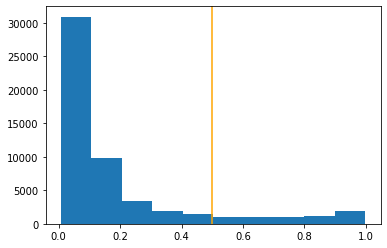

In [17]:
plt.hist(y_hat)
_ = plt.axvline(x=.5, color='orange')

In [18]:
auc = roc_auc_score(Y_test, y_hat)*100.0
print(auc)

87.26398084369049
